(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (18050, 806), number for Expceriments: 50
(806,)


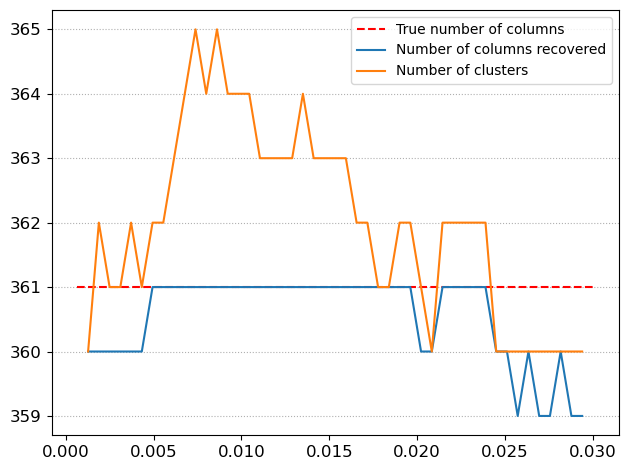

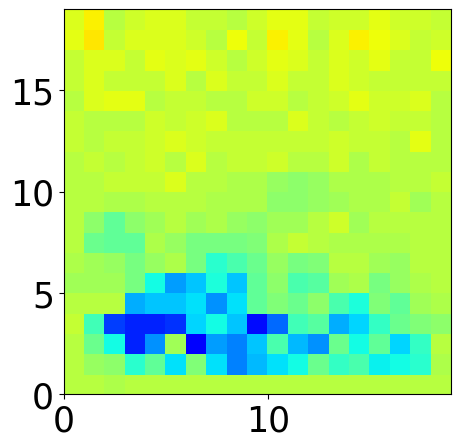

min number of recoveries 9, max number of recoveries 50


In [6]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
import copy
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix
from sklearn.cluster import DBSCAN
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.cluster import OPTICS

%matplotlib inline

cwd=os. getcwd()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


#Load True sensing matrix ##############################################################################################################################
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape) 
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000
MIN_CENTERS_LIST=[5] #Min number of centers for DBSCAN
eps_linspace=np.linspace(.00005,.03,50) #Epsilon values for DBSCAN


#If you only want to get cluster figure, you need to put your estimated Green's vecotrs in the col_list variable.
#Sensing matrix locations ##############################################################################################################################
decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
timescampstrs = [
"44_00-31-12",
"47_00-31-10",
"43_18-10-40",
"46_18-10-39",
"41_18-10-04",
"49_18-00-09",
"48_11-52-40",
"45_11-50-38",
"42_11-50-21",
"40_11-49-46",
"25_8-6-24",
"24_01-54-27",
"9_21-43-17",
"4_21-42-58",
"23_17-55-08",
"29_15-29-37",
"39_15-11-34",
"34_15-09-31",
"8_13-43-00",
"3_13-42-41",
"22_09-55-47",
"38_08-50-47",
"33_08-47-54",
"28_08-46-30",
"7_05-43-01",
"2_05-42-47",
"37_02-29-47",
"32_2-26-51",
"27_2-25-22",
"21_01-56-27",
"6_21-43-02",
"1_21-42-47",
"36_20-08-25",
"31_20-05-29",
"26_20-04-14",
"20_17-57-14",
"35_13-47-33",
"30_13-44-32",
"5_13-43-10",
"0_13-42-53",
"19_11-58-46",
"18_8-27-31",
"17_5-3-27",
"16_01-39-09",
"15_22-14-51",
"14_17-34-09",
"13_12-36-21",
"12_9-12-21",
"11_05-47-25",
"10_1-9-58"
]

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}


pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
  ########################################################################################################################################################################
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1)

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        try:
            decoder.load_state_dict(torch.load(curr_decoder))
        except:
            #curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]
            #decoder.load_state_dict(torch.load(curr_decoder))
            pass
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)



#col_list is the list of columns of the sensing matrix. 
col_list=get_cluster_data(decoder_locats)





print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))

X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
def DBSCAN_inners_fig(col_list, min_centers):
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    num_recovered_list=[]
    num_recovered_list_97=[]
    Cluster_size_diff_list=[]
    avg_cluster_size=[]
    smallest_cluster_used=[]
    next_largest_cluster=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]


    for eps in eps_linspace:
        DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        DBSCAN_fit.labels_
        X_clustered=X[DBSCAN_fit.labels_!=-1]
        len(X_clustered)
        cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
        sorted_cluster_sizes=sorted(cluster_sizes)
        try:
            min_accepted_cluster_size=sorted_cluster_sizes[-361]
        except:
            min_accepted_cluster_size=0
            #Cluster_size_diff_list.append(0)
        if len(cluster_sizes)>0:
            ghat_list_cores=[]
            ghat_list_avgs=[]

            for i in range(max(DBSCAN_fit.labels_)):
                
                if cluster_sizes[i]>=min_accepted_cluster_size:
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i and k in DBSCAN_fit.core_sample_indices_]
                    ghat_list_cores.append(oreinted_mean(X[cluster_cores]))
                    ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))
                    #if np.allclose(oreinted_mean(X[cluster_cores]),oreinted_mean(X[DBSCAN_fit.labels_==i])):
                        
                    

            medium_hat=np.vstack(ghat_list_cores)
            medium_hat=H.cat2complex(medium_hat)
            medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            max_inners=np.max(torch_inners, axis=0)
            num_recovered_list_CORES.append(len(max_inners[max_inners>T_hold]))

            #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
            #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

            medium_hat_avgs=np.vstack(ghat_list_avgs)
            medium_hat_avgs=H.cat2complex(medium_hat_avgs)
            medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
            torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
            max_inners_avgs=np.max(torch_inners_avgs, axis=0)
            #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
            #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
            num_clusters.append(len(cluster_sizes))

            num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
            num_recovered_list_97.append(len(max_inners_avgs[max_inners_avgs>.97]))
            num_really_bad.append(len(max_inners_avgs[max_inners_avgs<.95]))

            eps_list.append(eps)
            try:
                Cluster_size_diff_list.append(sorted_cluster_sizes[-361]-sorted_cluster_sizes[-362])
                next_largest_cluster.append(sorted_cluster_sizes[-362])
            except:
                Cluster_size_diff_list.append(0)
                next_largest_cluster.append(sorted_cluster_sizes[0])



            
            avg_cluster_size.append(np.mean(cluster_sizes))
            try:
                smallest_cluster_used.append(sorted_cluster_sizes[-361])
            except:
                smallest_cluster_used.append(sorted_cluster_sizes[0])

            if len(max_inners_avgs[max_inners_avgs>T_hold])<=360:
                ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])

    return num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list

for min_centers in MIN_CENTERS_LIST:
    num_clusters, num_recovered_list, num_recovered_list_97,num_really_bad,num_recovered_list_CORES,Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list=DBSCAN_inners_fig(col_list, min_centers)
    num_recovered_list=num_recovered_list_CORES
    if len(eps_list)>0:
        plt.figure()
        plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='True number of columns')  
            #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
        #plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)# Add subticks to the y-axis
        plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
        plt.tight_layout()
        R=-1
        L=1
        #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
       # plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')
        plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
        #plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
            #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
        plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')
       # plt.plot(eps_list[L:R], num_really_bad[L:R], label='Number of columns recovered with less than .95')

        plt.legend()
        plt.show()

        #plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}.pdf')
        #plt.close()#Takes 7 minouts to run
index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*361
total_num_cols=0
for j in range(len(decoder_locats)):
    col_list=get_cluster_data([decoder_locats[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(361):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/361)])


rho_hat=np.zeros((2, 361))
rho=np.zeros((2, 361))
rho_hat[0, :]=indivual_recoveries
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=75)
print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')